# Main experiment

Train a neural network to classify between three different classes of genomic sequences:
* Sequences from the reference genome
* Altered sequences based on information from Ensembl Variation build 110
* Altered sequences based on information from the GWAS Catalog

The last two represent sequences that include SNV without and with gwas-association, respectively.

The steps to run the experiment are:
1. Load the dataset from each chromosome, containing the sequences and their corresponding label.
2. Turn these datasets into an unique big general dataset
3. Apply the tokenization and pass into DataLoaders
4. Instantiate a DNABERT model for sequence classification between 3 classes
5. Train the neural network
6. Evaluate its performance

## Load necessary modules and libraries

In [3]:
import os
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel, DataCollatorWithPadding
from datasets import Dataset
from torch.utils.data import dataset, DataLoader
import pandas as pd
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.auto import tqdm
import evaluate
import seaborn as sns

## Load datasets

### Useful paths

In [4]:
databases_path = "/mnt/SILVER_DATA/Moy/Moys_dataset/"
# GWAS Catalog path
gwas_catalog_path = os.path.join(databases_path, "GWAS_Catalog_DATA/gwas_catalog_v1.0.2-associations_e110_r2023-09-25.tsv")
# Ensembl Variation path
ensembl_path = os.path.join(databases_path, "Ensembl/Variation/110/")
# Chromosomes' data path
chromosomes_path = os.path.join(ensembl_path, "chromosomes_data/")
# Reference genome path
ref_genome_path = os.path.join(databases_path,"Reference_Genome/GRCh38p14/Ensembl/Homo_sapiens_GRCh38_dna_primary_assembly.fa")
# GWAS Associated bed and sequences path
gwas_associated_bed_path = os.path.join(databases_path, "Ensembl/Variation/110/gwas_associated_sequences/beds")
gwas_associated_seq_path = os.path.join(databases_path, "Ensembl/Variation/110/gwas_associated_sequences/ref_sequences")
rand_bed_path = os.path.join(databases_path, "Ensembl/Variation/110/random_sequences/beds")
rand_seq_path = os.path.join(databases_path, "Ensembl/Variation/110/random_sequences/ref_sequences")
# Datasets path
dataset_path = os.path.join(ensembl_path, "chromosome_datasets/")

In [5]:
chromosomes = ['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y']
main_dataset = pd.read_csv(os.path.join(ensembl_path, 'to_dataloaders/chr1_dataset.csv'), index_col=0)
for chromosome in chromosomes:
    chr_dataset = pd.read_csv(os.path.join(ensembl_path, 'to_dataloaders/chr{}_dataset.csv'.format(chromosome)), index_col=0)
    main_dataset = pd.concat([main_dataset, chr_dataset])

# Uncomment if CustomTrainer is used
#main_dataset['label'] += 1

main_dataset.shape

/tmp/ipykernel_18614/1446307973.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  main_dataset = pd.concat([main_dataset, chr_dataset])


(1120243, 2)

In [6]:
main_dataset.label.value_counts()

label
0    485478
2    367305
1    267460
Name: count, dtype: int64

### Create PyTorch dataset objects with the HuggingFace module

In [7]:
tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M")

In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# Using the HuggingFace framework to create the Datasets and DataLoaders and split the data into train and test set
hf_dataset = Dataset.from_pandas(main_dataset).train_test_split(test_size=0.2)
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['seq', 'label', '__index_level_0__'],
        num_rows: 896194
    })
    test: Dataset({
        features: ['seq', 'label', '__index_level_0__'],
        num_rows: 224049
    })
})

### Tokenize sequences
Expensive process

In [10]:
def tokenize_function(example):
    return tokenizer(example["seq"], truncation=True)

tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)
tokenized_datasets

Map:   0%|          | 0/896194 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/224049 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['seq', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 896194
    })
    test: Dataset({
        features: ['seq', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 224049
    })
})

#### Remove unnecessary elements

In [11]:
tokenized_datasets = tokenized_datasets.remove_columns(["seq", "__index_level_0__"])
tokenized_datasets.set_format("torch")
tokenized_datasets.column_names

{'train': ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
 'test': ['label', 'input_ids', 'token_type_ids', 'attention_mask']}

### Create the DataLoaders

In [12]:
batch_sz = 64 #move to 16
train_set = DataLoader(tokenized_datasets["train"], batch_size=batch_sz, shuffle=True, collate_fn=data_collator)
test_set = DataLoader(tokenized_datasets["test"], batch_size=batch_sz, shuffle=True, collate_fn=data_collator)

Inspect the first batch to check everything is alright:

In [13]:
for batch in train_set:
    break
{k: v.shape for k, v in batch.items()}

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': torch.Size([64, 31]),
 'token_type_ids': torch.Size([64, 31]),
 'attention_mask': torch.Size([64, 31]),
 'labels': torch.Size([64])}

### Define and instantiate model

#### Check if cuda is available and define it as the processing device

In [14]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [15]:
# Model with 3 labels: [ref_sequences, alt_sequences, gwas_alt_sequences]
model = AutoModelForSequenceClassification.from_pretrained("zhihan1996/DNABERT-2-117M", num_labels=3)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['bert.encoder.layer.2.attention.self.query.bias', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.4.output.LayerNorm.weight', 'bert.encoder.layer.7.attention.self.key.bias', 'bert.pooler.dense.weight', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.2.output.LayerNorm.bias', 'bert.encoder.layer.2.attention.self.query.weight', 'bert.encoder.layer.6.attention.self.value.weight', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.5.attention.self.key.weight', 'bert.encoder.layer.5.output.LayerNorm.weight', 'bert.encoder.layer.5.attention.self.key.bias', 'bert.encoder.layer.7.attention.self.value.bias', 'bert.encoder.layer.7.output.LayerNorm.bias', 'bert.encoder.layer.1.attention.self.value.weight', 'bert.encoder.layer.11.output.LayerNorm.bias', 'classifier.weight', 'bert.encoder.layer.

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [16]:
model.config

BertConfig {
  "_name_or_path": "zhihan1996/DNABERT-2-117M",
  "alibi_starting_size": 512,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auto_map": {
    "AutoConfig": "zhihan1996/DNABERT-2-117M--configuration_bert.BertConfig",
    "AutoModel": "zhihan1996/DNABERT-2-117M--bert_layers.BertModel",
    "AutoModelForMaskedLM": "zhihan1996/DNABERT-2-117M--bert_layers.BertForMaskedLM",
    "AutoModelForSequenceClassification": "zhihan1996/DNABERT-2-117M--bert_layers.BertForSequenceClassification"
  },
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_

#### Check the model works by passing the first batch

In [17]:
outputs = model(**batch.to(device))
print(outputs.loss, outputs.logits.shape)

tensor(1.0604, device='cuda:0', grad_fn=<NllLossBackward0>) torch.Size([64, 3])


## Training and Evaluation
Define the optimizer, scheduler, and loss function

In [18]:
weight_decay = 1e-8
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=weight_decay)
num_epochs = 3
num_training_steps = num_epochs * len(train_set)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

42012


## Custom Training Loop
Training loop for classification tasks with unbalanced datasets.
> Change the label column in dataset adding 1 to the whole column

In [19]:
from transformers import Trainer


class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.0, 1.0, 2.0], device=model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(model=model, train_dataset=train_set)

In [20]:
def compute_accuracy(predictions, labels):
    # Implement your accuracy computation logic here
    # This could involve comparing predicted labels to actual labels
    # and computing the accuracy metric.
    # For example:
    correct_predictions = (predictions == labels).sum().item()
    total_predictions = len(labels)
    accuracy = correct_predictions / total_predictions
    return accuracy

In [21]:
progress_bar = tqdm(range(num_training_steps))
train_losses = []
train_accuracies = []

# Early stopping parameters
patience = 3  # Number of epochs with no improvement after which to stop
best_val_loss = float('inf')
counter = 0  # Counter for tracking epochs without improvement

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    total_accuracy = 0
    print(f"Epoch {epoch+1}\n-----------------------")

    for i, batch in enumerate(train_set):
        batch = {k: v.to(device) for k, v in batch.items()}
        #outputs = model(**batch)
        #loss = outputs.loss
        loss, outputs = trainer.compute_loss(model, batch, return_outputs=True)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy = compute_accuracy(predictions, batch['labels'])
        loss.backward()

        optimizer.step()
        total_loss += loss
        total_accuracy += accuracy
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
        if i % 1000 == 0:
             print("----------------\nLoss: {}".format(loss))
             print("\nAccuracy: {}\n----------------".format(accuracy))
             

    average_loss = total_loss / len(train_set)
    average_accuracy = total_accuracy / len(train_set)
    print("-"*8,"\n","Epoch {}: Average Loss: {}".format(epoch+1, average_loss))

    # Early stopping check    
    if average_loss < best_val_loss:
        torch.save(model.state_dict(), "/home/labsilver/Moy/models/dnabert.pth")
        best_val_loss = average_loss
        counter = 0  # Reset counter if there's improvement
    else:
        counter += 1
    if counter >= patience:
            print("Early stopping triggered.")
            break  # Stop training
    
    train_losses.append(average_loss)
    train_accuracies.append(average_accuracy)

  0%|          | 0/42012 [00:00<?, ?it/s]

Epoch 1
-----------------------
----------------
Loss: 1.1958754062652588

Accuracy: 0.421875
----------------
----------------
Loss: 0.6148900985717773

Accuracy: 0.28125
----------------
----------------
Loss: 0.6092537641525269

Accuracy: 0.34375
----------------
----------------
Loss: 0.5392376780509949

Accuracy: 0.390625
----------------
----------------
Loss: 0.7727342247962952

Accuracy: 0.171875
----------------
----------------
Loss: 0.6831099987030029

Accuracy: 0.234375
----------------
----------------
Loss: 0.6409198045730591

Accuracy: 0.359375
----------------
----------------
Loss: 0.5746217966079712

Accuracy: 0.3125
----------------
----------------
Loss: 0.6539207100868225

Accuracy: 0.25
----------------
----------------
Loss: 0.5485142469406128

Accuracy: 0.328125
----------------
----------------
Loss: 0.587041437625885

Accuracy: 0.40625
----------------
----------------
Loss: 0.6103031039237976

Accuracy: 0.234375
----------------
----------------
Loss: 0.48315

## Standard training loop

In [15]:
progress_bar = tqdm(range(num_training_steps))
train_losses = []

# Early stopping parameters
patience = 3  # Number of epochs with no improvement after which to stop
best_val_loss = float('inf')
counter = 0  # Counter for tracking epochs without improvement

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    print(f"Epoch {epoch+1}\n-----------------------")

    for i, batch in enumerate(train_set):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        total_loss += loss
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
        if i % 100 == 0:
             print("Loss: {}".format(loss))
             

    average_loss = total_loss / len(train_set)
    print("-"*8,"\n","Epoch {}: Average Loss: {}".format(epoch, average_loss))

    # Early stopping check    
    if average_loss < best_val_loss:
        torch.save(model.state_dict(), "/home/labsilver/Moy/models/dnabert.pth")
        best_val_loss = average_loss
        counter = 0  # Reset counter if there's improvement
    else:
        counter += 1
    if counter >= patience:
            print("Early stopping triggered.")
            break  # Stop training
    
    train_losses.append(average_loss)

  0%|          | 0/367590 [00:00<?, ?it/s]

Epoch 1
-----------------------
Loss: 1.0637295246124268
Loss: 1.1702585220336914
Loss: 0.9242050051689148
Loss: 1.2005733251571655
Loss: 1.1292930841445923
Loss: 1.1586413383483887
Loss: 1.1084024906158447
Loss: 1.1413960456848145
Loss: 1.1064064502716064
Loss: 1.0894410610198975
Loss: 1.0423803329467773
Loss: 1.0218384265899658
Loss: 1.2721714973449707
Loss: 1.0099130868911743
Loss: 1.134857177734375
Loss: 1.072811484336853
Loss: 1.087422251701355
Loss: 1.113666296005249
Loss: 1.1467797756195068
Loss: 1.0663812160491943
Loss: 1.106511116027832
Loss: 1.0830333232879639
Loss: 1.0738954544067383
Loss: 0.9863682985305786
Loss: 1.2351248264312744
Loss: 1.1349526643753052
Loss: 1.0711053609848022
Loss: 1.025098443031311
Loss: 1.0234369039535522
Loss: 1.0322034358978271
Loss: 1.0628880262374878
Loss: 1.1505389213562012
Loss: 1.1116677522659302
Loss: 1.0789353847503662
Loss: 1.1160171031951904
Loss: 1.0437536239624023
Loss: 1.0602350234985352
Loss: 1.0495884418487549
Loss: 1.0202350616455078

## Test Loop

In [19]:
progress_bar = tqdm(range(len(test_set)))
metric = evaluate.load("accuracy")
#roc_auc = evaluate.load("roc_auc", "multilabel")
model.eval()
for batch in test_set:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    #roc_auc.add_batch(predictions=predictions, references=batch["labels"])
    progress_bar.update(1)
print(metric.compute())#, roc_auc.compute())


  0%|          | 0/10503 [00:00<?, ?it/s]

{'accuracy': 0.32725330508550227}


## Evaluation

### Loss Curve

In [20]:
train_losses

[tensor(0.5927, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.5878, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.5876, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.5874, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.5876, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.5875, device='cuda:0', grad_fn=<DivBackward0>)]

In [21]:
new_losses = []
for loss in train_losses:
    new_losses.append(loss.item())

In [22]:
epoch = [epoch+1 for epoch in range(epoch)]
epoch

[1, 2, 3, 4, 5, 6]

<Axes: xlabel='epoch', ylabel='loss'>

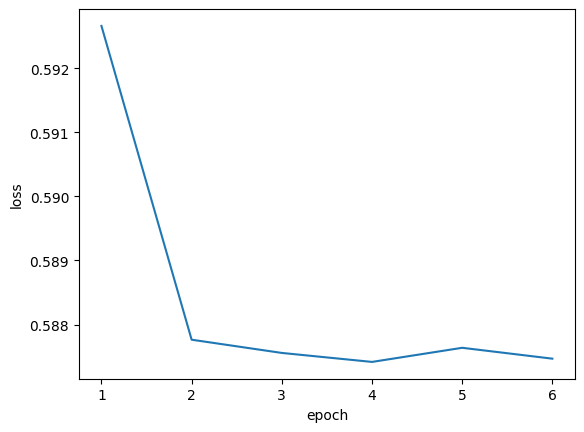

In [23]:
data = {
    'epoch': epoch,
    'loss': new_losses
}

sns.lineplot(data=data, x='epoch', y='loss')

In [25]:
train_accuracies

[0.3279903391006284,
 0.32815024891863215,
 0.32814183261242147,
 0.32815305435403574,
 0.3281474434832286,
 0.32814183261242147]

<Axes: xlabel='epoch', ylabel='accuracy'>

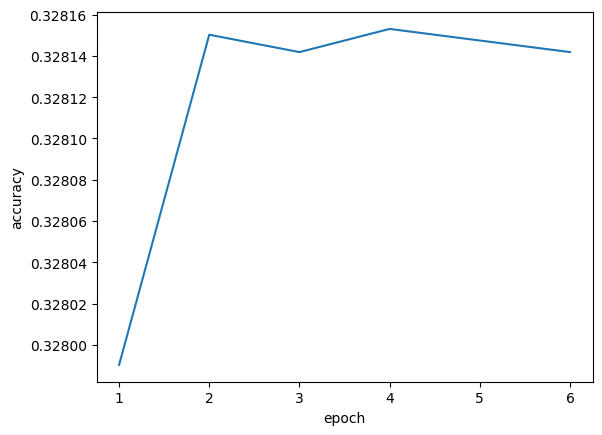

In [27]:
ac_data = {
    'epoch': epoch,
    'accuracy': train_accuracies
}

sns.lineplot(data=ac_data, x='epoch', y='accuracy')

In [36]:
metric

EvaluationModule(name: "accuracy", module_type: "metric", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions (`list` of `int`): Predicted labels.
    references (`list` of `int`): Ground truth labels.
    normalize (`boolean`): If set to False, returns the number of correctly classified samples. Otherwise, returns the fraction of correctly classified samples. Defaults to True.
    sample_weight (`list` of `float`): Sample weights Defaults to None.

Returns:
    accuracy (`float` or `int`): Accuracy score. Minimum possible value is 0. Maximum possible value is 1.0, or the number of examples input, if `normalize` is set to `True`.. A higher score means higher accuracy.

Examples:

    Example 1-A simple example
        >>> accuracy_metric = evaluate.load("accuracy")
        >>> results = accuracy_metric.compute(references=[0, 1, 2, 0, 1, 2], predictions=[0, 1, 1, 2, 1, 0])
        >>> print(results)
    

In [20]:
model.eval()
outputs = model(**batch)
outputs.logits

tensor([[ 0.2765, -0.3196, -0.0059],
        [ 0.2765, -0.3196, -0.0059],
        [ 0.2765, -0.3196, -0.0059],
        [ 0.2765, -0.3196, -0.0059],
        [ 0.2765, -0.3196, -0.0059],
        [ 0.2765, -0.3196, -0.0059],
        [ 0.2765, -0.3196, -0.0059],
        [ 0.2765, -0.3196, -0.0059],
        [ 0.2765, -0.3196, -0.0059]], device='cuda:0',
       grad_fn=<AddmmBackward0>)